In [1]:
!pip install tables
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pickle import dump, load
from sklearn.utils import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import matplotlib.pyplot as plt
from collections import OrderedDict

combined_data = pd.read_hdf("source_files/combined_data_C1.hdf5")

INPUT_COLUMNS = ["start_speed", "spin_rate", "spin_dir", "zone", "pitch_type"]
CONTEXT_COLUMNS = ["b_score", "p_score", "b_count", "s_count", "outs", "pitch_num", \
    "on_1b", "on_2b", "on_3b", "inning", "p_throws", "stand", "top"]
OUTPUT_COLUMNS = ["at_bat_score"]

inputs = combined_data[INPUT_COLUMNS].copy()
context = combined_data[CONTEXT_COLUMNS].copy()

#------------- One-Hot Encode  -----------------
inputs = pd.concat([inputs, pd.get_dummies(inputs.pitch_type)], axis=1)
inputs = inputs.drop(labels="pitch_type", axis=1)

context[["p_throws", "stand"]] = context[["p_throws", "stand"]] == "R"
context[["p_throws", "stand", "top"]] = context[["p_throws", "stand", "top"]].astype(int)
context = context.rename(columns={"p_throws":"p_isrighty", "stand":"b_isrighty", "top":"is_top_inning"})

combined_inputs = pd.concat([inputs, context], axis=1)
#Normalization
scaler = StandardScaler().fit(combined_inputs)
combined_inputs = scaler.transform(combined_inputs)
dump(scaler, open('scripts/scaler.pkl', 'wb'))

# nn_data = pd.concat([combined_inputs, combined_data[OUTPUT_COLUMNS]], axis=1)
# nn_data.to_hdf("../source_files/model_data.hdf5", key="df")

combined_inputs = torch.tensor(combined_inputs, dtype=torch.float32).cuda()
outputs = torch.tensor(combined_data[OUTPUT_COLUMNS].values, dtype=torch.float32).cuda()

del combined_data


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 59.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.7/380.7 kB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 80.6 MB/s eta 0:00:00:00:01


In [12]:
class FFNetPytorch(nn.Module):
  def __init__(self, input_size, output_size, hl1=100, hl2=25):
    super(FFNetPytorch, self).__init__()
    '''
    Define the layers of the neural network. One hidden layer and output layer.
    The activation function used in between the two layers is sigmoid.
    '''
    self.layer1 = nn.Linear(input_size, hl1, bias = True)
    self.layer2 = nn.Linear(hl1, output_size, bias=True)

    self.to(torch.float32)
    

  def forward(self, x):
    '''
    :param x: input to the model (N, NUM_FEATURES)

    :return:
      output: logits of the last layer of the model 
    '''
    x = torch.relu(self.layer1(x))
    x = self.layer2(x)

    return x

class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, i):
    return self.X[i], self.Y[i]
  
  def __len__(self):
    return self.X.shape[0]


Training

In [19]:
def wrapper():
  #------------- Train --------------
  X_train, X_test, Y_train, Y_test = \
      train_test_split(combined_inputs, outputs, test_size=0.2, random_state=42)

  NUM_FEATURES = X_train.shape[1]
  NUM_CLASSES = 1

  HIDDEN1_SIZE = 64
  HIDDEN2_SIZE = 4

  batch_size = 512
  max_epochs = 4

  print_every = 1
  test_every = 1
  SAVE_EVERY = 10

  LR = 1e-3


  SAVE_MODEL = False
  LOAD_MODEL = False
  SAVE_PATH = "HL1_" + str(HIDDEN1_SIZE) +"64"# + "_" + str(HIDDEN2_SIZE)
  MODEL_SAVE_PATH = "scripts/batting/models/" + SAVE_PATH + ".pt"
  TRAIN_LOSSES_SAVE_PATH = "scripts/batting/trainingloss/" + SAVE_PATH + ".csv"
  TEST_LOSSES_SAVE_PATH = "scripts/batting/testloss/" + SAVE_PATH + ".csv"
  ACCURACY_SAVE_PATH = "scripts/batting/accuracies/" + SAVE_PATH + ".csv"

  CONV_SIZE = 10 #CONVERGENCE_WINDOW_SIZE
  CONVERGENCE_THRESHOLD = 0.0003

  model = FFNetPytorch(NUM_FEATURES, NUM_CLASSES, hl1=HIDDEN1_SIZE, hl2=HIDDEN2_SIZE)
  train_losses =[]
  test_losses=[]
  train_accuracies = []

  if LOAD_MODEL:
      try:
        model = torch.load(MODEL_SAVE_PATH)
        train_losses = np.fromfile(TRAIN_LOSSES_SAVE_PATH, sep=',').tolist()
        test_losses = np.fromfile(TEST_LOSSES_SAVE_PATH, sep=',').tolist()
        train_accuracies = np.fromfile(ACCURACY_SAVE_PATH, sep=',').tolist()
      except FileNotFoundError:
        pass
    
  #print(model)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
  loss_fn = nn.MSELoss()
  #torch.manual_seed(314159)
  device = torch.device("cuda")

  dataset_train = CustomDataset(X_train, Y_train)
  dataset_test = CustomDataset(X_test, Y_test)

  model = model.to(device)
  model.train()
  train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)#, num_workers = 4)
  test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)#, num_workers = 4)

  accuracies = []
  max_epoch = max_epochs + len(train_losses)
  train_dif = 0
  epoch = len(train_losses)

  while epoch < max_epoch and (train_dif > CONVERGENCE_THRESHOLD or train_dif == 0):
    batch_losses = []
    batch_accuracies = []
    for batch_idx, (data, target) in enumerate(train_loader):
      # print(data.device)
      # data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      prediction = torch.round(output)
      accuracy = torch.sum(prediction == target)/len(target)
      loss.backward()
      optimizer.step()
      batch_losses.append(loss.item())
      batch_accuracies.append(accuracy.item())
    
    #if epoch > 3: scheduler.step()
    test_accuracy = torch.mean(torch.Tensor(batch_accuracies)).item()
    accuracies.append(test_accuracy)
    train_losses.append(torch.mean(torch.Tensor(batch_losses)).item())
    train_dif = (np.max(train_losses[-CONV_SIZE:])-np.min(train_losses[-CONV_SIZE:]))/np.mean(train_losses[-CONV_SIZE:])

    model.eval()
    batch_losses = []

    if epoch % test_every == 0:
      for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        batch_losses.append(loss.item())

      test_losses.append(torch.mean(torch.Tensor(batch_losses)).item())

    if (epoch % SAVE_EVERY == 0) & (epoch != 0):
      print("----- SAVED -----")
      torch.save(model, MODEL_SAVE_PATH)
      np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
      np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
      np.asarray(accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')

    if epoch % print_every == 0:
      print('{epoch}/{max_epoch}, Train Loss: {loss:.6f}, Test Loss: {test_loss:.6f}, Accuracy: {accuracy:.4f}%, Difference {diff:.3f}%, lr: {lr}'.format(
                  epoch=epoch, max_epoch=max_epoch, loss=train_losses[-1], test_loss=test_losses[-1], \
                  accuracy = test_accuracy*100, diff=train_dif*100, lr=scheduler.get_last_lr()[0]))

    epoch += 1

  if SAVE_MODEL:
    torch.save(model, MODEL_SAVE_PATH)
    np.asarray(train_losses).tofile(TRAIN_LOSSES_SAVE_PATH, sep=',')
    np.asarray(test_losses).tofile(TEST_LOSSES_SAVE_PATH, sep=',')
    np.asarray(accuracies).tofile(ACCURACY_SAVE_PATH, sep=',')

%prun wrapper()
    

0/4, Train Loss: 3.113567, Test Loss: 3.101752, Accuracy: 14.0321%, Difference 0.000%, lr: 0.001
1/4, Train Loss: 3.103962, Test Loss: 3.099320, Accuracy: 14.3278%, Difference 0.309%, lr: 0.001
2/4, Train Loss: 3.101627, Test Loss: 3.097502, Accuracy: 14.3025%, Difference 0.384%, lr: 0.001
3/4, Train Loss: 3.099954, Test Loss: 3.096504, Accuracy: 14.2583%, Difference 0.438%, lr: 0.001
 

         37234875 function calls (37151313 primitive calls) in 138.670 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 10680428   53.886    0.000   53.886    0.000 1218141261.py:31(__getitem__)
 10680428    9.821    0.000   14.356    0.000 collate.py:170(<genexpr>)
    20868    7.961    0.000   61.847    0.003 fetch.py:49(<listcomp>)
    41736    7.708    0.000    7.708    0.000 {built-in method torch.stack}
    16692    7.260    0.000    7.260    0.000 {method 'run_backward' of 'torch._C._EngineBase' objects}
62604/20868    7.220    0.000   34.781    0.002 collate.py:84(default_collate)
    37560    4.891    0.000   19.247    0.001 {built-in method builtins.all}
 10780619    4.643    0.000    4.814    0.000 {built-in method builtins.len}
    20876    3.988    0.000  102.271    0.005 dataloader.py:719(_next_data)
    16692    3.485    0.000   10.232    0.001 adam.py:229(_single_tensor_adam)
    41736    2.714    0.000    2

In [16]:
import matplotlib.pyplot as plt


#training_4_1 = np.fromfile("trainingloss/HL2_4_1.csv", sep=',').tolist()

training_128_1 = np.fromfile("scripts/batting/trainingloss/HL1_128.csv", sep=',').tolist()
testing_128_1 = np.fromfile("scripts/batting/testloss/HL1_128.csv", sep=',').tolist()

training_64 = np.fromfile("scripts/batting/trainingloss/HL1_64.csv", sep=',').tolist()
testing_64 = np.fromfile("scripts/batting/testloss/HL1_64.csv", sep=',').tolist()

plt.figure()
plt.plot(training_64)
plt.plot(testing_64)
plt.plot(training_128_1)
plt.plot(testing_128_1)
# for i in range(0,7):
#     plt.plot(np.fromfile("batting/trainingloss/HL2_" + str(2**i) + "_1.csv", sep=',').tolist())
plt.grid()
# plt.ylim(3.08, 3.2)
plt.xlabel("Epoch")
plt.ylabel("MSE Training Loss")
plt.legend(["Training", "Testing"])
# plt.legend(["HL Size 1", "HL Size 2", "HL Size 4", "HL Size 8", "HL Size 16", "HL Size 32", "HL Size 64"])
plt.title("Loss vs. Epoch")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'scripts/batting/trainingloss/HL1_128.csv'

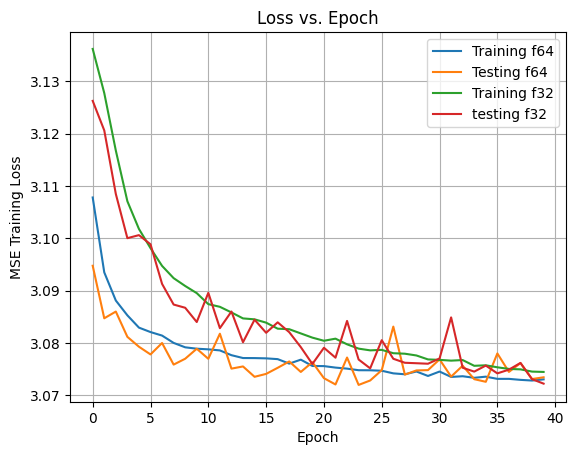

In [21]:
import matplotlib.pyplot as plt
training_64 = np.fromfile("batting/trainingloss/HL1_6464.csv", sep=',').tolist()
testing_64 = np.fromfile("batting/testloss/HL1_6464.csv", sep=',').tolist()

training_64f32 = np.fromfile("batting/trainingloss/HL1_64f32.csv", sep=',').tolist()
testing_64f32 = np.fromfile("batting/testloss/HL1_64f32.csv", sep=',').tolist()

plt.figure()
plt.plot(training_64)
plt.plot(testing_64)
plt.plot(training_64f32)
plt.plot(testing_64f32)
plt.legend(["Training f64", "Testing f64", "Training f32", "testing f32"])

plt.grid()

plt.xlabel("Epoch")
plt.ylabel("MSE Training Loss")
# plt.legend(["HL Size 1", "HL Size 2", "HL Size 4", "HL Size 8", "HL Size 16", "HL Size 32", "HL Size 64"])
plt.title("Loss vs. Epoch")

plt.show()

<a list of 16 text.Text objects>

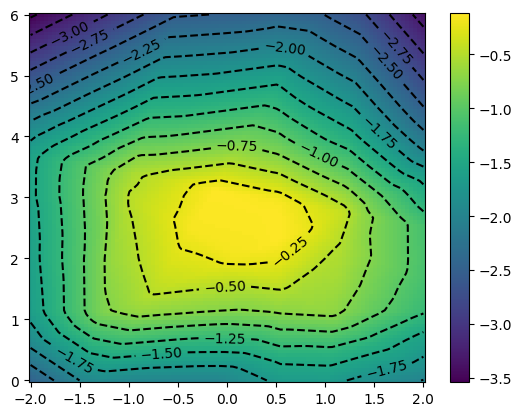

In [52]:
context = {
    "b_score": 0,
    "p_score": 0,
    "b_count": 3,
    "s_count": 0,
    "outs": 0,
    "pitch_num": 4,
    "on_1b": 0,
    "on_2b": 0,
    "on_3b": 0,
    "inning": 1,
    "p_isrighty": 1,
    "b_isrighty": 0,
    "is_top_inning": 1
}
indexes = [key for key, val in context.items()]
values = [val for key, val in context.items()]
context = pd.Series(values, index=indexes, dtype=float)


inputs = {
    "start_speed": 90,
    "spin_rate": 1300,
    "spin_dir": 159,
    "px": 0.5,
    "pz": 0.2,
    "pitch_type": "FF"
}

PITCH_TYPES = ['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 'KN', 'SI', 'SL']

pitches = [inputs["pitch_type"]==val for val in PITCH_TYPES]
pitches = pd.Series(pitches, index=PITCH_TYPES, dtype=float)

model_path = "scripts/batting/models/HL1_6464.pt"
model = torch.load(model_path)
model.eval()
torch.no_grad()
inputs = pd.Series([inputs["start_speed"], inputs["spin_rate"], inputs["spin_dir"], inputs["px"], inputs["pz"]], index=["start_speed", "spin_rate", "spin_dir", "px", "pz"], dtype=float)

pitch = pd.concat([inputs, pitches, context])

scaler = load(open('scaler_batting.pkl', 'rb'))

# pitch = scaler.transform(np.array(pitch.values).reshape(1, -1))

px, pz = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(0, 6, 100))
scores = np.zeros((100, 100))
for i in range(len(px)):
    for j in range(len(pz)):
        pitch["px"], pitch["pz"] = px[i,j], pz[i,j]
        to_model = scaler.transform(np.array(pitch.values).reshape(1, -1))
        scores[i, j] = model(torch.tensor(to_model))



plt.figure()
plt.pcolor(px, pz, scores)
plt.colorbar()
cs = plt.contour(px, pz, scores, 15, colors="black")
plt.clabel(cs)

In [19]:

import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
parser.add_argument('data', metavar='DIR',
                    help='path to dataset')
parser.add_argument('-a', '--arch', metavar='ARCH', default='resnet18',
                    choices=model_names,
                    help='model architecture: ' +
                        ' | '.join(model_names) +
                        ' (default: resnet18)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N',
                    help='mini-batch size (default: 256), this is the total '
                         'batch size of all GPUs on the current node when '
                         'using Data Parallel or Distributed Data Parallel')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--wd', '--weight-decay', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)',
                    dest='weight_decay')
parser.add_argument('-p', '--print-freq', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')
parser.add_argument('--world-size', default=-1, type=int,
                    help='number of nodes for distributed training')
parser.add_argument('--rank', default=-1, type=int,
                    help='node rank for distributed training')
parser.add_argument('--dist-url', default='tcp://224.66.41.62:23456', type=str,
                    help='url used to set up distributed training')
parser.add_argument('--dist-backend', default='nccl', type=str,
                    help='distributed backend')
parser.add_argument('--seed', default=None, type=int,
                    help='seed for initializing training. ')
parser.add_argument('--gpu', default=None, type=int,
                    help='GPU id to use.')
parser.add_argument('--multiprocessing-distributed', action='store_true',
                    help='Use multi-processing distributed training to launch '
                         'N processes per node, which has N GPUs. This is the '
                         'fastest way to use PyTorch for either single node or '
                         'multi node data parallel training')

best_acc1 = 0


def main():
    args = parser.parse_args()

    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    if args.gpu is not None:
        warnings.warn('You have chosen a specific GPU. This will completely '
                      'disable data parallelism.')

    if args.dist_url == "env://" and args.world_size == -1:
        args.world_size = int(os.environ["WORLD_SIZE"])

    args.distributed = args.world_size > 1 or args.multiprocessing_distributed

    ngpus_per_node = torch.cuda.device_count()
    if args.multiprocessing_distributed:
        # Since we have ngpus_per_node processes per node, the total world_size
        # needs to be adjusted accordingly
        args.world_size = ngpus_per_node * args.world_size
        # Use torch.multiprocessing.spawn to launch distributed processes: the
        # main_worker process function
        mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, args))
    else:
        # Simply call main_worker function
        main_worker(args.gpu, ngpus_per_node, args)


def main_worker(gpu, ngpus_per_node, args):
    global best_acc1
    args.gpu = gpu

    if args.gpu is not None:
        print("Use GPU: {} for training".format(args.gpu))

    if args.distributed:
        if args.dist_url == "env://" and args.rank == -1:
            args.rank = int(os.environ["RANK"])
        if args.multiprocessing_distributed:
            # For multiprocessing distributed training, rank needs to be the
            # global rank among all the processes
            args.rank = args.rank * ngpus_per_node + gpu
        dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                world_size=args.world_size, rank=args.rank)
    # create model
    if args.pretrained:
        print("=> using pre-trained model '{}'".format(args.arch))
        model = models.__dict__[args.arch](pretrained=True)
    else:
        print("=> creating model '{}'".format(args.arch))
        model = models.__dict__[args.arch]()

    if args.distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if args.gpu is not None:
            torch.cuda.set_device(args.gpu)
            model.cuda(args.gpu)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            args.batch_size = int(args.batch_size / ngpus_per_node)
            args.workers = int((args.workers + ngpus_per_node - 1) / ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        else:
            model.cuda()
            # DistributedDataParallel will divide and allocate batch_size to all
            # available GPUs if device_ids are not set
            model = torch.nn.parallel.DistributedDataParallel(model)
    elif args.gpu is not None:
        torch.cuda.set_device(args.gpu)
        model = model.cuda(args.gpu)
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
            model.features = torch.nn.DataParallel(model.features)
            model.cuda()
        else:
            model = torch.nn.DataParallel(model).cuda()

    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().cuda(args.gpu)

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            if args.gpu is None:
                checkpoint = torch.load(args.resume)
            else:
                # Map model to be loaded to specified single gpu.
                loc = 'cuda:{}'.format(args.gpu)
                checkpoint = torch.load(args.resume, map_location=loc)
            args.start_epoch = checkpoint['epoch']
            best_acc1 = checkpoint['best_acc1']
            if args.gpu is not None:
                # best_acc1 may be from a checkpoint from a different GPU
                best_acc1 = best_acc1.to(args.gpu)
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True

    # Data loading code
    traindir = os.path.join(args.data, 'train')
    valdir = os.path.join(args.data, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))

    if args.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    else:
        train_sampler = None

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

    if args.evaluate:
        validate(val_loader, model, criterion, args)
        return

    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
        adjust_learning_rate(optimizer, epoch, args)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch, args)

        # evaluate on validation set
        acc1 = validate(val_loader, model, criterion, args)

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)

        if not args.multiprocessing_distributed or (args.multiprocessing_distributed
                and args.rank % ngpus_per_node == 0):
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'best_acc1': best_acc1,
                'optimizer' : optimizer.state_dict(),
            }, is_best)


def train(train_loader, model, criterion, optimizer, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if args.gpu is not None:
            images = images.cuda(args.gpu, non_blocking=True)
        target = target.cuda(args.gpu, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i)


def validate(val_loader, model, criterion, args):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if args.gpu is not None:
                images = images.cuda(args.gpu, non_blocking=True)
            target = target.cuda(args.gpu, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(optimizer, epoch, args):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] [-a ARCH] [-j N] [--epochs N]
                             [--start-epoch N] [-b N] [--lr LR] [--momentum M]
                             [--wd W] [-p N] [--resume PATH] [-e]
                             [--pretrained] [--world-size WORLD_SIZE]
                             [--rank RANK] [--dist-url DIST_URL]
                             [--dist-backend DIST_BACKEND] [--seed SEED]
                             [--gpu GPU] [--multiprocessing-distributed]
                             DIR
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

In [20]:
%tb

SystemExit: 2

In [22]:
combined_inputs.device

device(type='cuda', index=0)